# Introduction
* This notebook contains an analysis of the "Wine" dataset from kaggle, which contains the chemical components of several wines: https://www.kaggle.com/akram24/wine-pca.
* The original goal of the dataset is to train a classifier (the dataset is labeled), but I'm going to ignore the class labels and perform clustering and then dimension reduction (PCA and T-SNE) for visualization.
* Although in most clustering problems this is not an option, I'm going to use the labels to evaluate the performance of the different clustering algorithms, mostly out of curiosity, rather than for future decisions.

#### The notebook is divided into the following parts:
* [Part 1: Notebook Preparation](#part_1)
* [Part 2: Data Exploration](#part_2)
* [Part 3: Clustering](#part_3)
* [Part 4: Dimension Reduction](#part_4)
* [Part 5: Evaluation](#part_5)

<a id='part_1'></a>
# Part 1: Notebook Preparation

## Import

In [1]:
# Data analysis
import pandas as pd
import numpy as np
import pandas_profiling

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, dbscan, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score

%autosave 60

Autosaving every 60 seconds


## Config

In [2]:
trainFileName = 'Wine.csv'
CLASS_LABEL = 'Customer_Segment'

<a id='part_2'></a>
# Part 2: Data Exploration

##### For reference, the columns in the dataset are:
* Alcohol
* Malic_acid
* Ash
* Ash_Alcanity  
* Magnesium
* Total_Phenols
* Flavanoids
* Nonflavanoid_Phenols
* Proanthocyanins
* Color_Intensity
* Hue
* OD280
* Proline 

##### Conclusions based on data exploration:
* All the columns are numeric.
* There are no significant outliers.
* There are no missing values.
* The file contains data that is too clean, which clearly indicates a cleaning process that was previously performed on the data.

In [3]:
df = pd.read_csv(trainFileName)
X = df.drop(CLASS_LABEL, axis=1)
true_labels = df[CLASS_LABEL]

In [4]:
X.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
pandas_profiling.ProfileReport(X)

Number of variables,13
Number of observations,178
Total Missing (%),0.0%
Total size in memory,18.2 KiB
Average record size in memory,104.4 B
Numeric,13
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


<a id='part_3'></a>
# Part 3: Clustering
* I'm going to try these types of clustering algorithms:
    * K-means
    * Agglomerative clustering
    * Gaussian mixtures
* all of these algorithms require setting the k clusters as a parameter, so first I will choose the number of clusters using the "elbow" graph of the K-means errors.

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.astype(float))

## Choosing the number of clusters 
* For choosing the number of clusters I will use the K-means algorithm and the "elbow" graph.

In [7]:
cluster_range = range(1, 10)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans(n_clusters=num_clusters).fit(X_scaled)
    cluster_errors.append(clusters.inertia_)
    
cluster_errors_df = pd.DataFrame({"num_clusters":cluster_range, "cluster_errors":cluster_errors})

Text(0,0.5,'Sum of squared errors (SSE)')

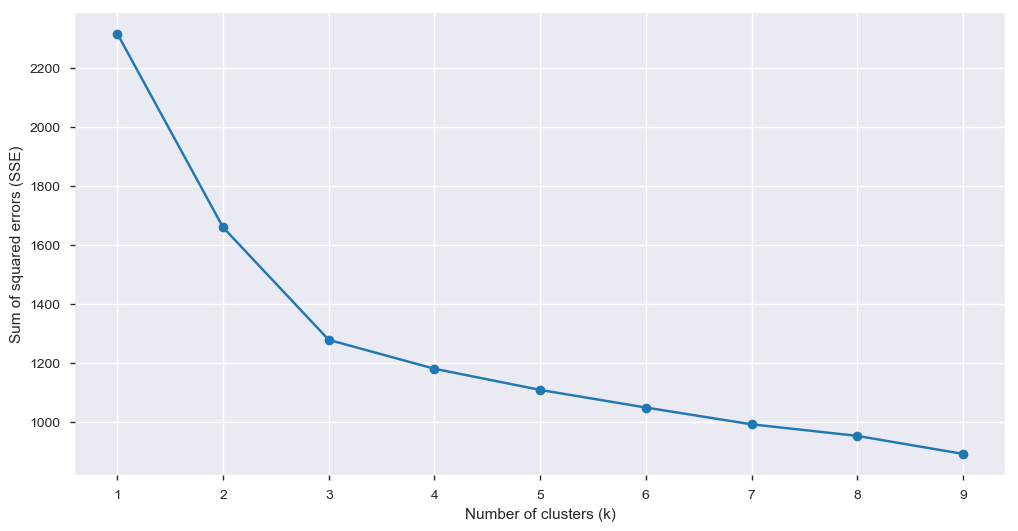

In [8]:
plt.figure(figsize=(12,6))
plt.plot(cluster_errors_df.num_clusters, cluster_errors_df.cluster_errors, marker = "o")
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared errors (SSE)')

* As can be seen in the graph above, there is a pretty clear elbow at k = 3, indicating that 3 is the best number of clusters.

In [9]:
selected_k = 3

## Make the clusters

In [10]:
# K-means
kmeans = KMeans(n_clusters=selected_k).fit(X_scaled)
kmeans_labels = kmeans.labels_

# Agglomerative clustering
agcl = AgglomerativeClustering(n_clusters=selected_k).fit(X_scaled)
agcl_labels = agcl.labels_

# Gaussian mixtures
gmm = GaussianMixture(n_components=selected_k).fit(X_scaled)
gmm_labels = gmm.predict(X_scaled)

<a id='part_4'></a>
# Part 4:  Plotting by Using Dimension Reduction

## PCA and T-SNE

In [11]:
labelsConfig = [{'name': 'true labels', 'labels': true_labels}, 
                {'name': 'K-means', 'labels': kmeans_labels},
                {'name': 'Agglomerative', 'labels': agcl_labels},
                {'name': 'Gaussian mixtures', 'labels': gmm_labels}]

In [12]:
# pca
pca = PCA(n_components=2).fit(X_scaled)
pca_projected = pca.fit_transform(X_scaled)

# t-sne
tnse_projected = TSNE(n_components=2).fit_transform(X_scaled)

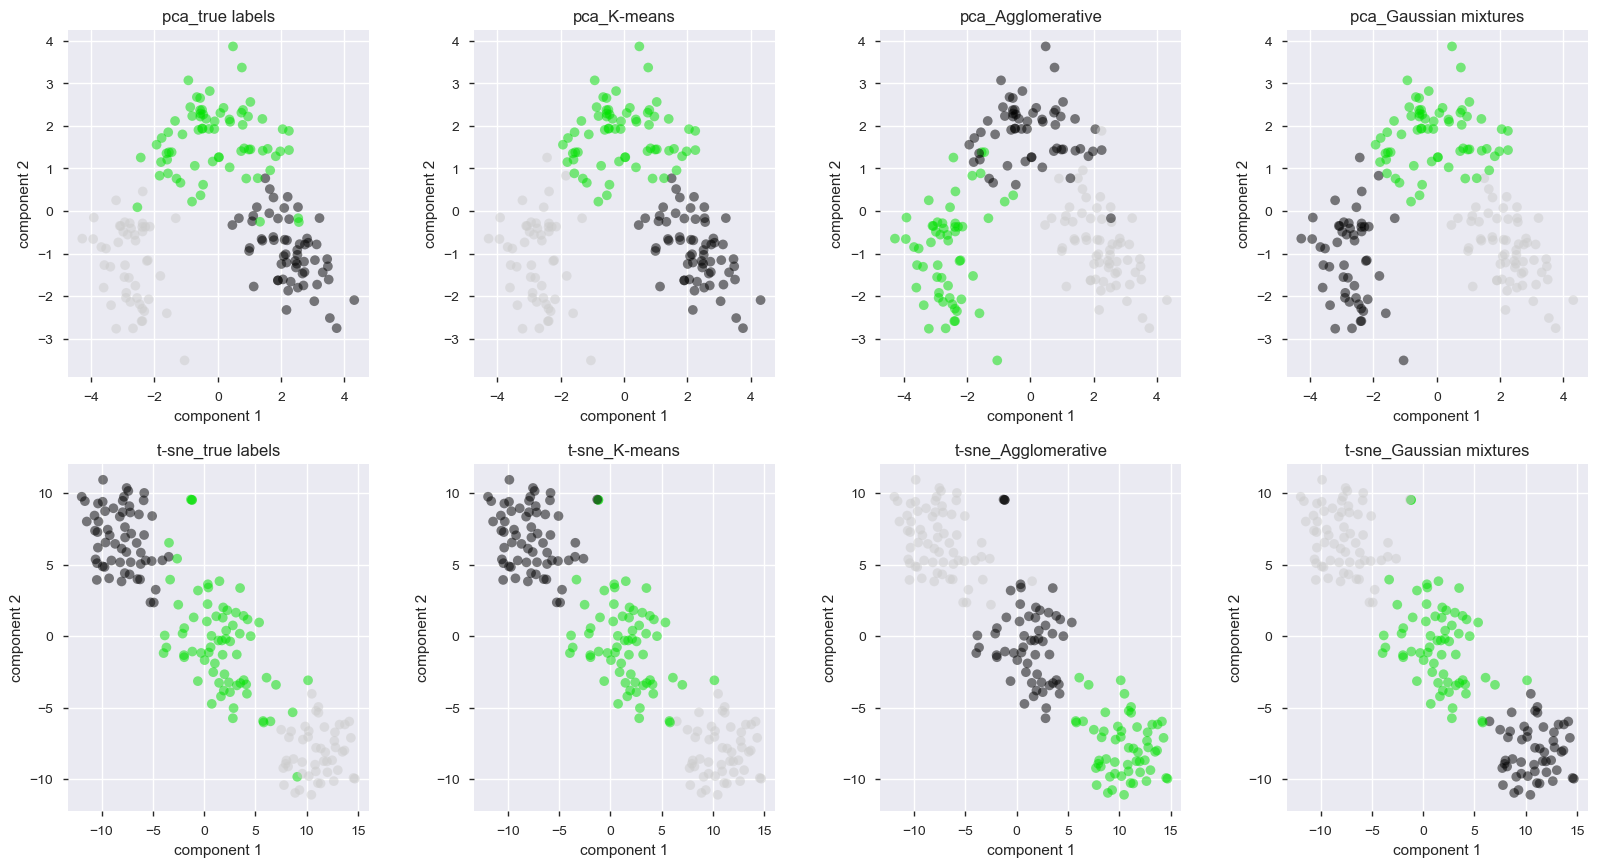

In [13]:
for i,currConfig in enumerate(labelsConfig):
    label_name = currConfig.get("name")
    curr_labels = currConfig.get("labels")
    
    # pca
    plt.subplot(2,4,i+1)
    plt.scatter(pca_projected[:, 0], 
                pca_projected[:, 1],
                c=curr_labels, 
                edgecolor='none', 
                alpha=0.5,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.title('pca_'+label_name)
    
    # t-sne
    plt.subplot(2,4,i+5)
    plt.scatter(tnse_projected[:, 0],
                tnse_projected[:, 1],
                c=curr_labels, 
                edgecolor='none', 
                alpha=0.5,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.title('t-sne_'+label_name)
    
plt.subplots_adjust(top=1.5, bottom=0.08, left=0.10, right=2, hspace=0.25, wspace=0.35)
plt.show()

<a id='part_5'></a>
# Part 5: Evaluation

* Because the clustering doesn't give a named class, I can't use regular precision and recall. Therefore, I will use Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) to compare the clusters and the true labels.
* As can be seen from the following measurements, the clustering algorithms with the best performance are gaussian mixtures and K-means.

In [14]:
for i, currConfig in enumerate(labelsConfig[1:]):
    label_name = currConfig.get("name")
    curr_labels = currConfig.get("labels")
    
    ARI = adjusted_rand_score(true_labels, curr_labels)
    NMI = normalized_mutual_info_score(true_labels, curr_labels, average_method='arithmetic')
    print(f"ARI score of {label_name} clustering is: {round(ARI,4)}")
    print(f"NMI score of {label_name} clustering is: {round(NMI,4)}\n")

ARI score of K-means clustering is: 0.8975
NMI score of K-means clustering is: 0.8759

ARI score of Agglomerative clustering is: 0.7899
NMI score of Agglomerative clustering is: 0.7865

ARI score of Gaussian mixtures clustering is: 0.8975
NMI score of Gaussian mixtures clustering is: 0.8759

